In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

df = pd.read_csv('https://bit.ly/perch_csv_data')
perch_full = df.to_numpy()

perch_weight = np.array([5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0, 110.0,
       115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0, 130.0,
       150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0, 197.0,
       218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0, 514.0,
       556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0, 820.0,
       850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0, 1000.0,
       1000.0])

train_input, test_input, train_target, test_target = train_test_split(perch_full, perch_weight, random_state=42)

poly = PolynomialFeatures(degree=5, include_bias=False) #5제곱까지 특성 만들기
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

lr = LinearRegression()
lr.fit(train_poly, train_target)
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))


0.9999999999938144
-144.40744532797535


### **규제(Regularization)**
> 과도한 학습을 방지하는 것이다.
선형 회귀 모델의 경우 특성에 곱해지는 계수(기울기)의 크기를 작게 만든다.  
55개의 특성으로 훈련한 선형 회귀 모델의 계수를 **규제**하여 훈련 세트의 점수를 낮추고,  
테스트 점수를 높이도록 한다.  

- 규제를 적용하기 위해 정규화를 해야하며, 이전에 다루었던 평균과 표준편차를 통해 표준점수로 바꾸어서 과대적합을 해결하고자 한다.
- 사이킷런에서 제공하는 변환기인 StandardScaler 클래스를 사용하여 정규화 작업을 진행한다.
- 특성마다 계산하기 때문에 55개의 평균과 표준편차가 들어있다.

In [3]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_poly)
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

### **릿지(Ridge) 회귀**
> 계수를 제곱한 값을 기준으로 규제를 적용하며, 선호하는 규제 적용 방식 알고리즘이다.

In [4]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

#많은 특성을 사용했어도 좋은 성능을 내고 있다.

0.9896101671037343
0.9790693977615391


### **alpha**
> 규제의 양을 나타내는 변수이다.  
alpha값이 크면 큐제 강도가 강해지고  
alpha값이 작으면 계수를 줄이는 역할이 줄어들며 선형 회귀 모델과 유사해진다.

### **alpha값에 대한 R²값의 그래프 그리기**
> 최적의 alpha값을 구해보자

In [5]:
import matplotlib.pyplot as plt

train_score = [] #훈련세트의 점수를 저장할 list
test_score = [] #테스트 세트의 점수를 저장할 list

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100] #0.001에서 100까지 10배씩 늘려가며 릿지 회귀 모델을 훈련한다.
for alpha in alpha_list:
  ridge = Ridge(alpha=alpha)
  #표준 점수로 정규화 된 데이터로 규제 훈련
  ridge.fit(train_scaled, train_target)
  #훈련 점수와 테스트 점수 저장
  train_score.append(ridge.score(train_scaled, train_target))
  test_score.append(ridge.score(test_scaled, test_target))

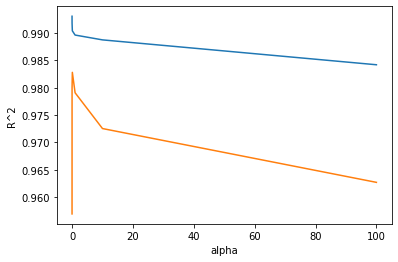

In [6]:
plt.plot(alpha_list, train_score)
plt.plot(alpha_list, test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

#알파값이 0.001부터 10배씩 늘어나기 때문에 굉장히 촘촘하여 판단하기 어렵다.

### **상용로그를 사용하여 alpha값의 각 값을 동일한 간격으로 나타낸다.**
> log() : 자연로그(자연상수e를 밑으로 한다)  
log10() : 상용로그(10을 밑으로 한다)

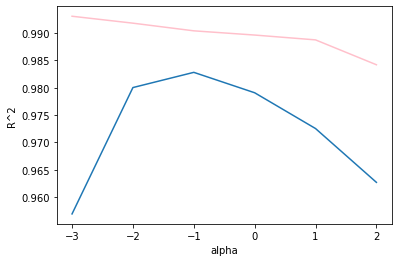

In [7]:
plt.plot(np.log10(alpha_list), train_score, color="pink")
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

#-3일 때에는 점수차이가 크기 때문에 과대 적합이다.
#점점 알파값이 증가할 수록 과소적합으로 간다.
#두 그래프가 가장 가깝고, 테스트 세트의 점수가 가장 높은 -1 
#즉, 10^-1 = 0.1 이 가장 적합한 alpha값이다.

### **가장 적합한 alpha수치(규제값)로 최종 모델 훈련**

In [8]:
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)
print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570368
0.9827976465386954


### **라쏘(Lasso) 회귀**
> 계수의 절대값을 기준으로 규제를 적용하며, 계수를 0으로 만들 수도 있다.

### **라쏘 회귀의 기본 점수 확인**

In [9]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

#과대적합을 잘 해결해준다.

0.9897898972080961
0.9800593698421884


### **alpha값에 대한 R²값의 그래프 그리기**
> 최적의 alpha값을 구해보자

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18778.697957792032, tolerance: 518.2793833333334
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12972.821345401393, tolerance: 518.2793833333334
  positive)


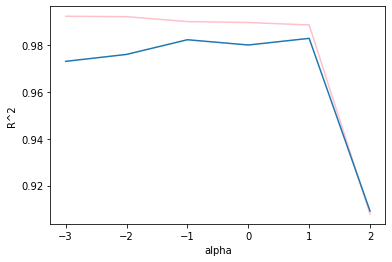

In [18]:
train_score = [] #훈련세트의 점수를 저장할 list
test_score = [] #테스트 세트의 점수를 저장할 list

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100] #0.001에서 100까지 10배씩 늘려가며 라쏘 회귀 모델을 훈련한다.
for alpha in alpha_list:
  #lasso = Lasso(alpha=alpha)
  lasso = Lasso(alpha=alpha, max_iter=10000) #반복횟수를 적당히 늘려준다.
  #표준 점수로 정규화 된 데이터로 규제 훈련
  lasso.fit(train_scaled, train_target)
  #훈련 점수와 테스트 점수 저장
  train_score.append(lasso.score(train_scaled, train_target))
  test_score.append(lasso.score(test_scaled, test_target))

plt.plot(np.log10(alpha_list), train_score, color="pink")
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

#ConvergenceWarning
#라쏘 모델은 최적의 계수를 찾기 위해 반복적인 계산을 수행한다.
#반복 횟수가 부족할 때 발생하는 경고이다.
#반복 횟수를 충분히 늘려주면 된다. 하지만 너무 늘리면 굉장히 오래 걸리기 때문에
#지금과 같은 문제에서는 큰 영향이 없기 때문에 적당히 늘려준다.

### **가장 적합한 alpha수치(규제값)로 최종 모델 훈련**

In [13]:
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)
print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


### **라쏘 모델의 다른 목적**
> 라쏘 모델은 계수를 0으로 만들 수 있다. 이는 불필요한 특성이라는 의미로 생각할 수 있으며,  
위의 라쏘 모델에서 계수가 0이 된 특성의 개수를 파악해보자.

In [14]:
print(np.sum(lasso.coef_ == 0))

#55개의 특성 중 15개의 특성만 사용하였다.

40
